###**All you need is a Good init**###

In [fastai 2019](https://course.fast.ai/part2) Jeremy covers implementing [All you need is a Good init](https://arxiv.org/pdf/1511.06422.pdf) over [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/07a_lsuv.ipynb)

In his lectures (as a part of Part II rules) he's building the fastai library from scratch. 

Here I shall try to implement a `HookCallback` which implements the paper. 
I've also added a few modifications which are necessary in my opinion. 

First I shall implement it for the `text.vision` setup. Experiment with Pretrained as `True` and `False`





In [0]:
! pip install git+https://github.com/fastai/fastai_dev

So in `Deep Learning for coders` the course by fastai in the first lesson Jeremy implements a pet classifier which is available over [here](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb). I'm going to building on top of that. 

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import Hooks

In [0]:
bs = 32   # uncomment this line if you run out of memory even after clicking Kernel->Restart


In [16]:
path = untar_data(URLs.PETS); path


PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)


In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

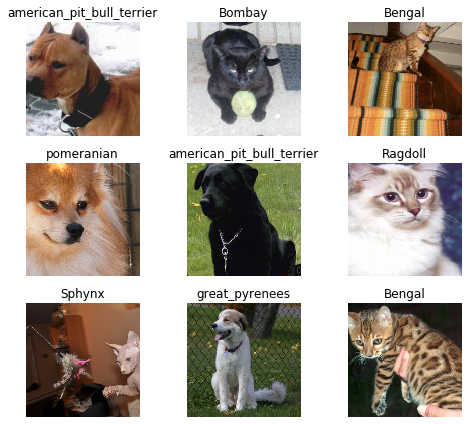

In [20]:
data.show_batch(rows=3, figsize=(7,6))


In [0]:
from fastai.callbacks import ActivationStats

`ActivationStats` is a HookCallBack present in the fastai library. Here are the [documentation](https://docs.fast.ai/callbacks.hooks.html#ActivationStats) and [source](https://github.com/fastai/fastai/blob/master/fastai/callbacks/hooks.py#L82).

It stores the mean and std of activations of all layers that are passed to it. 


In [0]:
from torch.nn import Conv2d

I've written a few functions to see bool status of `requires_grad` which indicates if a layer is forzen or not/if it will be learning. 

In [0]:
import collections

def requires_grad_counter(m:nn.Module)->Optional[bool]:
    ps = list(m.parameters())
    return collections.Counter([it.requires_grad for it in ps])


def requires_grad_bool(m:nn.Module)->Optional[bool]:
    ps = list(m.parameters())
    return ps[0].requires_grad

### **LSUV_HookCallBack** ###


I have imported the code for `HookCallBack`, `ActivationStats`. 
I have modified the `HookCallBack` so that `ActivationStats` will only be registering the `Conv2d` layers to calculate the mean and std of the activations. 


`LSUV_HookCallBack` is the CallBack for the paper:
HookCallBack registers hooks (defined in the hook func in the class) for the layers I am passing to it. 
The hook registered returns the mean and std(which we are trying to normalize) of the activations for a layer. 

Before trainning begins I am taking a batch from the databunch.
I go layer by layer and I keep dividing the weights of that layer by the variance of the activations. 

Here is the psuedo code from the paper. 

    Pre-initialize network with orthonormal matrices as in Saxe et al. (2014)
      for each layer L do
        while |Var(BL) − 1.0| ≥ Tolvar and (Ti < Tmax) do
          do Forward pass with a mini-batch
          calculate Var(BL)
          WL = WL / Var(BL)
        end while
      end for

One subtle difference you will notice is that Jeremy in his notebook as well as I have divided the weights not by the root of the variance but by the variance. 
We can do a couple of iterations with this factor after initially testing.

        
        

In [0]:
class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if isinstance(m, Conv2d)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()

class ActivationStats(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        '''
        Here is the CallBack for the paper:
        HookCallBack registers hooks (defined in the hook func below) for the layers I am passing to it. 
        The hook registered returns the std(which we are trying to normalize)
        
        Before trainning begins I am taking a batch from the databunch.
        I go layer by layer and I keep dividing the weights of that layer by the variance of the activations. 
        

        '''
        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

        self.remove() 

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()


In [25]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=ActivationStats)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]


First let's have a look at the layers and check which have `requires_grad` set as `True`. 

In [0]:
def has_params(m:nn.Module)->bool:
    "Check if `m` has at least one parameter"
    return len(list(m.parameters())) > 0


In [0]:
 mods = [m for m in flatten_model(learn.model)
                            if isinstance(m, Conv2d)]

In [28]:
for it in mods:
  print(requires_grad_counter(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Counter({False: 1}) Conv2d(128, 1

As you can see in it's default state none of the Conv2D layers are unfrozen.
This is done by default by the fastai library based on the [ULMFit](https://arxiv.org/pdf/1801.06146.pdf) paper by Jeremy et.al. This paper shows the benefits gradually unfreezing the layers. 

Now why is that important? 

As Jeremy mentions in his lectures (As per my understanding):

It is extremly important to to have good initilizations for the purposes of learning. When we start learning we want the activations of our layers to have mean 0 and std as 1. This helps in learning because as we're training deep layers we don't want the activations to explode or vanish. 

However, since all of the Conv2D layers are frozen they won't be learning anything. So we want perform this activity for layers that are unfrozen.  


In [0]:
learn.freeze_to(-2)


In [31]:
 mods = [m for m in flatten_model(learn.model)
                            if isinstance(m, Conv2d)]
for it in mods:
  print(requires_grad_counter(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Counter({False: 1}) Conv2d(128, 1

We see here we can unfreeze the Conv2D layers by the `freeze_to` func. 

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

By default only the items in `(1): Sequential` are unfrozen. 




### **BASELINE** ###

So let's try the default setting. In this setting we're using the pretrained model for resnet30

In [34]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=ActivationStats)
learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,error_rate,time
0,1.008615,0.365868,0.114344,01:50
1,0.662402,0.347306,0.110284,01:51
2,0.449351,0.231594,0.080514,01:55
3,0.330042,0.224404,0.071042,01:56
4,0.261298,0.203329,0.070365,01:55


Let's checkout the mean and std for the activations. X Axis defines the layer number. 

In [0]:
layers_len = len(learn.activation_stats.modules)

means = [learn.activation_stats.stats[0][i].mean() for i in range(layers_len)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(layers_len)]

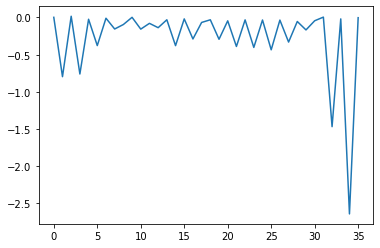

In [37]:
plt.plot(means)

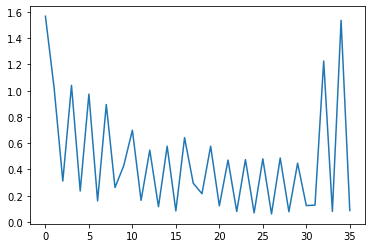

In [38]:
plt.plot(stds)

First let's try out this technique only on all layers that are not forzen by default. I'm not sure of the behaviour for the `BatchNorm` layer. But we shall see. 

Adding the `has_params` func from the fastai library and adding the condition that the parameters should have `requires_grad` set as `True`. 

In [0]:
def has_params(m:nn.Module)->bool:
    "Check if `m` has at least one parameter"
    return len(list(m.parameters())) > 0

class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if has_params(m) and requires_grad_bool(m)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()

class ActivationStats(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        '''
        Here is the CallBack for the paper:
        HookCallBack registers hooks (defined in the hook func below) for the layers I am passing to it. 
        The hook registered returns the std(which we are trying to normalize)
        
        Before trainning begins I am taking a batch from the databunch.
        I go layer by layer and I keep dividing the weights of that layer by the variance of the activations. 
        

        '''
        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx, mod)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

        self.remove() 

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()

I'm printing the std for the process. We can see how the std is converging on to 1. 

In [43]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack,ActivationStats])
learn.fit_one_cycle(5)

0 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.30728286504745483
0.4484558403491974
0.8037204146385193
0.9733064770698547
0.9972638487815857
0.9997292160987854
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.7545009851455688
0.995147705078125
0.9999505281448364
2 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1.5631694793701172
0.991115152835846
1.0001728534698486
3 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.6305303573608398
0.9758666753768921
0.9991491436958313
4 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1.0346474647521973
1.000527262687683
5 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.6339687705039978
0.9869344234466553
0.9997552037239075
6 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1.139829397201538
1.0009099245071411
7 BatchNorm

epoch,train_loss,valid_loss,error_rate,time
0,1.495207,0.757058,0.230041,01:55
1,0.950202,0.526879,0.164411,01:54
2,0.680864,0.404345,0.131935,01:54
3,0.544746,0.350513,0.115020,01:54
4,0.388527,0.334020,0.108931,01:55


So, clearly that didn't work if we're looking at the error rate. 

In [0]:
layers_len = len(learn.activation_stats.modules)

means = [learn.activation_stats.stats[0][i].mean() for i in range(layers_len)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(layers_len)]

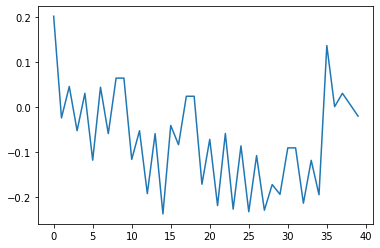

In [45]:
plt.plot(means)

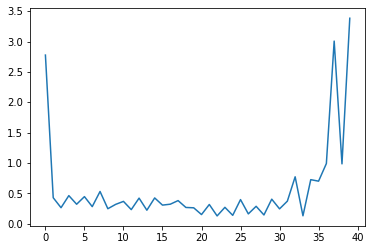

In [46]:
plt.plot(stds)

Seem like std for the activations in the last layers has actually gone up. 

Keep in mind we're still trying with a pretrained model 


### pretrained=False ###
Let's try with pretrained set to False

In [49]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=ActivationStats,pretrained=False)
learn.unfreeze()
learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,error_rate,time
0,4.473606,3.903148,0.940460,02:06
1,4.113922,3.477778,0.924899,02:06
2,3.751937,3.421106,0.880244,02:07
3,3.379098,3.021091,0.823410,02:07
4,3.091667,2.841817,0.775372,02:05


Let's checkout the mean and std for the activations. X Axis defines the layer number. 

In [0]:
layers_len = len(learn.activation_stats.modules)

means = [learn.activation_stats.stats[0][i].mean() for i in range(layers_len)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(layers_len)]

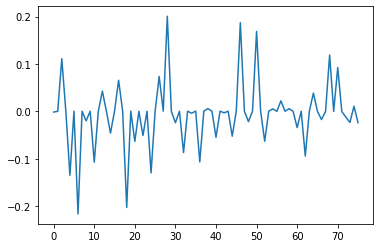

In [51]:
plt.plot(means)

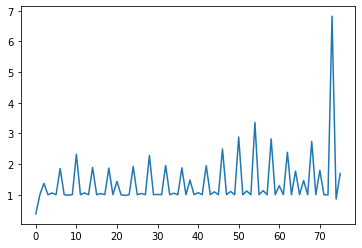

In [52]:
plt.plot(stds)

In [57]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack,ActivationStats],pretrained=False)
learn.unfreeze()
learn.fit_one_cycle(5)

0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
0.12944702804088593
0.9999998807907104
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.9999948740005493
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
1.3836114406585693
0.9999999403953552
3 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.9999949336051941
4 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
0.9051938056945801
1.0000001192092896
5 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.9999950528144836
6 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
1.7313892841339111
1.0
7 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.9999948740005493
8 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
0.8507806658744812
1.0
9 BatchNorm2d(64, eps=1e-05, momentu

epoch,train_loss,valid_loss,error_rate,time
0,3.790586,3.683014,0.925575,02:06
1,3.743856,3.564291,0.907984,02:07
2,3.508799,3.304871,0.861976,02:06
3,3.141965,2.809401,0.783491,02:06
4,2.825634,2.559343,0.738160,02:08


So, there's an improvement in performance. 

Here I'm trying with the pretrained model after unfreezing all the layers. 

In [58]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=ActivationStats)
learn.unfreeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.083959,0.751720,0.223275,02:06
1,1.021521,0.974534,0.249662,02:06
2,0.707196,0.559092,0.165088,02:07
3,0.366112,0.284102,0.085250,02:06
4,0.206789,0.238180,0.074425,02:06


In [53]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack,ActivationStats])
learn.unfreeze()
learn.fit_one_cycle(5)


0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
0.5769408345222473
1.0
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.34284520149230957
0.6002209782600403
0.9143491387367249
0.9904356598854065
0.9990493059158325
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
1.887245535850525
0.9999998211860657
3 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.40407055616378784
0.9641643762588501
0.9999256730079651
4 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
1.379089117050171
1.0
5 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1.211487054824829
0.9982249140739441
1.0000133514404297
6 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
1.8398405313491821
0.9999998807907104
7 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.43092936277389526
0.9

epoch,train_loss,valid_loss,error_rate,time
0,1.451866,1.066247,0.315291,02:08
1,1.142663,0.960697,0.281461,02:06
2,0.787331,0.534274,0.170501,02:05
3,0.454550,0.329617,0.095399,02:06
4,0.221876,0.284569,0.083221,02:07


Let's checkout the mean and std for the activations. X Axis defines the layer number. 

In [0]:
layers_len = len(learn.activation_stats.modules)

means = [learn.activation_stats.stats[0][i].mean() for i in range(layers_len)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(layers_len)]

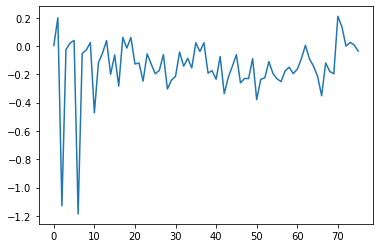

In [55]:
plt.plot(means)

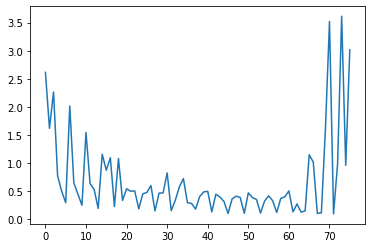

In [56]:
plt.plot(stds)

Below are a few more experiments I tried. A couple of variations of the LSUV modue. For example changing the factor the variance is being multiplied with etc. 

In [0]:

import math 
class LSUV_HookCallBack_Sqrt(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= math.sqrt(hook.stored[1])
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()



class LSUV_HookCallBack_Sq(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= math.pow(hook.stored[1],2)
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()



class LSUV_HookCallBack_Sq(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= math.pow(hook.stored[1],1.5)
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()

class LSUV_HookCallBack_xx(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]*2
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()


class LSUV_HookCallBack_xxx(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]*3
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()


class LSUV_HookCallBack_idx(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]*idx
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()
        


In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack_Sqrt,ActivationStats])
learn.fit_one_cycle(1)



0
0.5965524315834045
0.7723680138587952
0.8788447976112366
0.9374671578407288
0.9682287573814392
0.9839861989021301
0.991960883140564
0.9959722757339478
0.9979841709136963
0.9989916086196899
0.9994957447052002
1
0.7001799941062927
0.8367675542831421
0.9147499799728394
0.9564257264137268
0.9779701232910156
0.9889237284660339
0.9944465160369873
0.9972193241119385
0.9986087679862976
0.9993041753768921
2
0.2344624251127243
0.4842131733894348
0.6958543658256531
0.8341788053512573
0.9133339524269104
0.955685019493103
0.9775913953781128
0.9887322187423706
0.9943501353263855
0.9971710443496704
0.9985846281051636
0.9992920160293579
3
1.0453519821166992
1.022424578666687
1.0111501216888428
1.0055595636367798
1.0027761459350586
1.0013870000839233
1.0006933212280273
4
0.1944638043642044
0.4409804940223694
0.664063572883606
0.8149011135101318
0.9027186036109924
0.9501151442527771
0.9747385382652283
0.9872885346412659
0.9936239719390869
0.9968069791793823
0.9984021782875061
0.9992007613182068
5
1.43

epoch,train_loss,valid_loss,error_rate,time
0,0.736851,0.307038,0.096752,02:19


In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

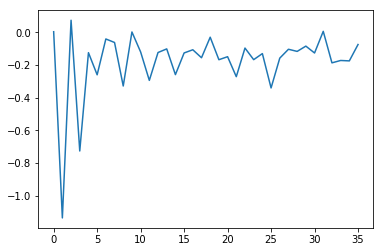

In [0]:
plt.plot(means)

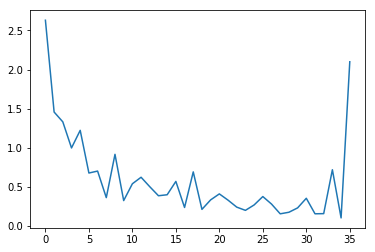

In [0]:
plt.plot(stds)

In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack_Sq,ActivationStats])
learn.fit_one_cycle(1)



0
0.6131209135055542
1.2771060466766357
0.8848843574523926
1.063057541847229
0.9698879718780518
1.0154048204421997
0.9923855066299438
1.0038292407989502
0.9980906844139099
1.0009560585021973
1
0.6577245593070984
1.2330421209335327
0.9005566835403442
1.0537667274475098
0.9741542935371399
1.0131789445877075
0.9934750199317932
1.0032784938812256
0.9983647465705872
1.0008186101913452
2
0.23798701167106628
2.049855947494507
0.6984548568725586
1.196549892425537
0.9141860604286194
1.0458821058273315
0.9778192639350891
1.0112782716751099
0.9944081902503967
1.0028076171875
0.9985991716384888
1.0007011890411377
3
1.0082587003707886
0.9958961009979248
1.0020582675933838
0.9989725351333618
1.000514030456543
4
0.19273202121257782
2.277839422225952
0.662580132484436
1.228515863418579
0.9022142291069031
1.0527981519699097
0.9746022820472717
1.0129460096359253
0.9935891032218933
1.003220796585083
0.9983935356140137
1.0008043050765991
5
1.3460478782653809
0.8619255423545837
1.077122688293457
0.96353483

epoch,train_loss,valid_loss,error_rate,time
0,0.734493,0.315022,0.100135,02:21


In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

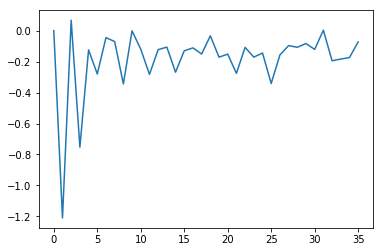

In [0]:
plt.plot(means)

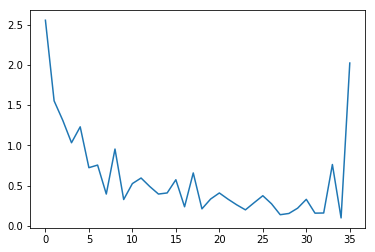

In [0]:
plt.plot(stds)

Pretrained = False

In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,pretrained=False)
learn.fit_one_cycle(5)



epoch,train_loss,valid_loss,error_rate,time
0,4.477866,3.783200,0.944520,02:12
1,4.217132,3.738859,0.924222,02:08
2,3.836927,3.765436,0.897158,02:20
3,3.464271,3.099820,0.842355,02:10
4,3.211449,2.912679,0.794317,02:10


In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=LSUV_HookCallBack_Sq,pretrained=False)
learn.fit_one_cycle(5)



0
0.20354431867599487
0.9999999403953552
1
1.0862829685211182
0.9999999403953552
2
0.91098952293396
0.9999999403953552
3
2.0200233459472656
1.0
4
1.1859595775604248
1.0
5
2.1849796772003174
1.0
6
0.9368482828140259
0.9999998807907104
7
1.970059871673584
1.0
8
0.9851251840591431
1.0
9
1.7250924110412598
0.9999999403953552
10
1.112108826637268
1.0
11
0.9322288632392883
0.9999998807907104
12
1.641937255859375
1.0
13
0.9825705885887146
0.9999998211860657
14
2.2094435691833496
1.0
15
1.0278828144073486
0.9999999403953552
16
1.8405685424804688
1.0
17
1.0161983966827393
1.0
18
1.97809898853302
1.0
19
1.2425801753997803
0.9999999403953552
20
0.9189213514328003
0.9999999403953552
21
1.6487213373184204
0.9999999403953552
22
1.0834577083587646
0.9999999403953552
23
2.219040632247925
1.0000001192092896
24
0.9922202825546265
1.0000001192092896
25
2.511077642440796
0.9999999403953552
26
0.9113543629646301
1.0
27
2.6858971118927
0.9999998807907104
28
1.0238949060440063
0.9999998211860657
29
2.0682103

epoch,train_loss,valid_loss,error_rate,time
0,4.093897,3.466738,0.906631,02:23


In [0]:
#Every Epoch 


In [0]:

class LSUV_HookCallBack_EveryEpoch(HookCallback):

    def on_epoch_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_epoch_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()